### Setup

In [1]:
# Import useful packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import seaborn as sns
from scipy.sparse import csr_array
from scipy.sparse import lil_array
from scipy.sparse import save_npz
from scipy.sparse import load_npz
import os
from datetime import datetime, timedelta

In [2]:
# Read in the data

# Check which server we're on (in case the data is in different places on different servers)
import socket
hostname = socket.gethostname()

# Get paths to data
if hostname == "blpc1" or hostname == "blpc2":
    data_path = "/datax/scratch/nstieg/"
elif hostname == "cosmic-gpu-1":
    data_path = "/mnt/cosmic-gpu-1/data0/nstiegle/"
else:
    raise Exception("Data path not known")

full_dataset_path = data_path + "25GHz_higher.pkl"
coherent_dataset_path = data_path + "25GHz_higher_coherent.pkl"
incoherent_dataset_path = data_path + "25GHz_higher_incoherent.pkl"

# Read in data
coherent = pd.read_pickle(coherent_dataset_path)
# incoherent = pd.read_pickle(incoherent_dataset_path)
# df = pd.read_pickle(full_dataset_path)

### Analyze Adjacent Hits


In [3]:
# Load in all the distances and masks to a np array of [[distances, mask], ...] for each source
path = os.path.expanduser("~") + "/" + "BL-COSMIC-2024-proj/frequency_adjacency/adjacent_in_each_source/" # Place to save arrays
files = os.listdir(path) # All the files and directories in the folder
files = [f for f in files if os.path.isfile(path + '/' + f)] # Just get the folders
files = [f.split('.') for f in files] # Take off the extension
files = np.array(files) # Turn into a numpy array so I can slice off the extensions
files = np.unique(files[:, 0]) # Get the unique filenames (sources observed)
sources_data = [] # Append (source.distances.npz, source.mask.npz)
sources = []
for file in files:
    distances = load_npz(path + "/" + file + ".distances.npz")
    mask = load_npz(path + "/" + file + ".mask.npz")
    sources_data.append((distances, mask))
    sources.append(file.split('_')[0])

sources_data = np.array(sources_data, dtype='object')

#### Look at the first source

##### Investigate Generally

In [4]:
# Look at first source
# Sources are loaded in alphabetically
source_to_look_at = 0
distances = sources_data[source_to_look_at, 0]
mask = sources_data[source_to_look_at, 1]
print(sources[source_to_look_at])
grouped = coherent.groupby('source_name')
first_source = grouped.get_group(sources[source_to_look_at]).reset_index(drop=True)
print(first_source.shape) 
print(distances.shape)
print(mask.shape)

2535280716217508992
(51451, 16)
(51451, 51451)
(51451, 51451)


<Axes: xlabel='tstart_h', ylabel='signal_frequency'>

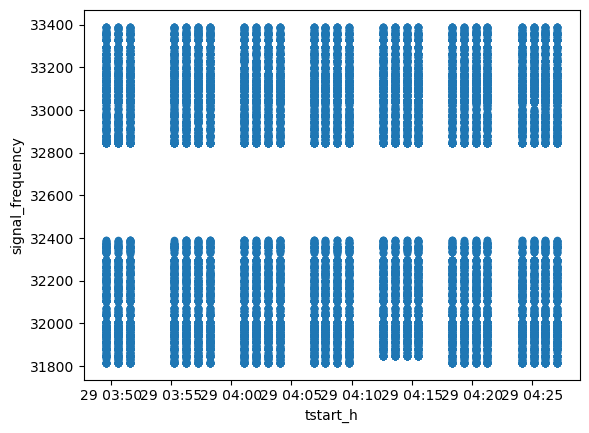

In [5]:
first_source.plot.scatter("tstart_h", "signal_frequency")

In [6]:
# Figure out how many 'collisions' there are
print(f"There are {np.sum(mask)} collisions in this file")

There are 499607 collisions in this file


There are 260849 collisions in the file with a distance of 0Hz
There are 487001 collisions in the file with a distance of 100Hz


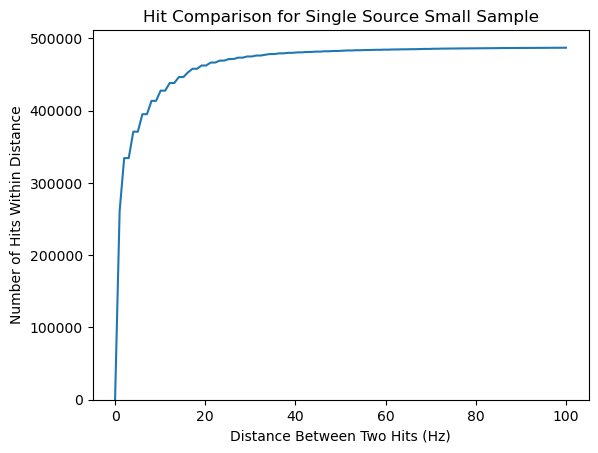

In [7]:
# Look at about how many are within certain frequencies
print(f"There are {(distances[mask] == 0).sum()} collisions in the file with a distance of 0Hz")
print(f"There are {(distances[mask] <= 100e-6).sum()} collisions in the file with a distance of 100Hz")

xaxis = np.linspace(-0.001, 100, 100)
yaxis = np.array([(distances[mask] <= frequency_threshold*1e-6).sum() for frequency_threshold in xaxis])

plt.plot(xaxis, yaxis)
plt.xlabel("Distance Between Two Hits (Hz)")
plt.ylabel("Number of Hits Within Distance")
plt.title("Hit Comparison for Single Source Small Sample")
plt.ylim(bottom=0)
plt.show()

There are 260849 collisions in the file with a distance of 0Hz
There are 487001 collisions in the file with a distance of 100Hz


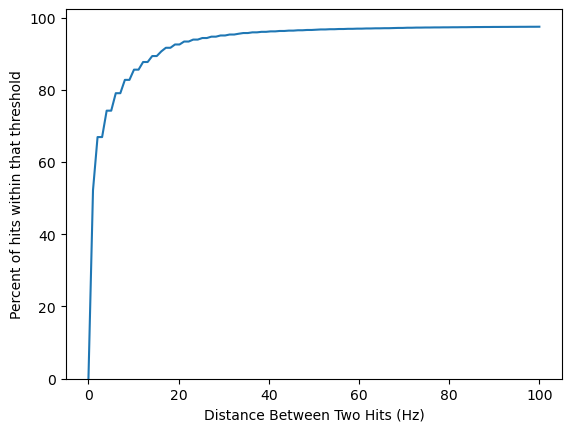

In [8]:
# Look at about how many are within certain frequencies
print(f"There are {(distances[mask] == 0).sum()} collisions in the file with a distance of 0Hz")
print(f"There are {(distances[mask] <= 100e-6).sum()} collisions in the file with a distance of 100Hz")

xaxis = np.linspace(-0.001, 100, 100)
yaxis = np.array([(distances[mask] <= frequency_threshold*1e-6).sum() for frequency_threshold in xaxis])

plt.plot(xaxis, yaxis / np.sum(mask) * 100)
plt.xlabel("Distance Between Two Hits (Hz)")
plt.ylabel("Percent of hits within that threshold")
plt.ylim(bottom=0)
plt.show()

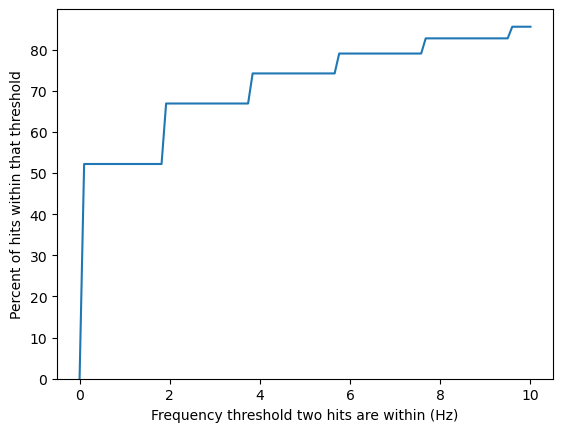

In [9]:
xaxis = np.linspace(-0.001, 10, 100)
yaxis = np.array([(distances[mask] <= frequency_threshold*1e-6).sum() for frequency_threshold in xaxis])

plt.plot(xaxis, yaxis / np.sum(mask) * 100)
plt.xlabel("Frequency threshold two hits are within (Hz)")
plt.ylabel("Percent of hits within that threshold")
plt.ylim(bottom=0)
plt.show()

In [10]:
# Let's look at how many collisions there were within a threshold
# Want to do (distances <= threshold) & mask to get all the values which are under the threshold
# including zeroes which are let in by the mask
# However, if we turn all the 0s in the sparse array to Trues, it's not sparse anymore (so it's super slow)
# So how do we maintain the sparsity?
# Well, we can look for the opposite first, the values which are outside the threshold
# Then we can remove those from the mask so there's a new mask just contains the values we care about below the threshold 
# Then the number of collisions within that threshold is the number of Trues in the new mask
# And if we want to get those distances (or the hits which are close to each other), then we can do distances[new_mask] (or new_mask.nonzero())
def find_collisions_at_threshold(threshold):
    # Get those outside threshold
    outside_threshold = distances > threshold

    # Remove those outside threshold from the mask
    # We want to do mask & (~outside_threshold), but note that ~outside_threshold produces an array which is mostly true
    # So instead we'll have to do mask - outside_threshold 
    # (which does xor, so it will have values which are in mask but not outside_threshold, and those in outside_threshold but not mask)
    # Finally, to get rid of values in outside_threshold but not mask, we'll and by mask
    new_mask = mask.multiply(mask - outside_threshold)

    return new_mask

In [11]:
## Confirm the result with how many distances are zero
# Set threshold
threshold_hz = 0
threshold = threshold_hz * 1e-6
new_mask = find_collisions_at_threshold(threshold)
print(new_mask.sum())

260849


In [12]:
## Confirm the result with how many distances are <= 100Hz
# Set threshold
threshold_hz = 100
threshold = threshold_hz * 1e-6
new_mask = find_collisions_at_threshold(threshold)
print(new_mask.sum())

487001


In [13]:
# See how many hits did vs. didn't have another hit within 1000hz
num_hits_with_associated_hit = len(np.unique(np.concatenate(mask.nonzero())))
print(f"{num_hits_with_associated_hit} hits had another hit within {1000}Hz out of {len(first_source)} hits ({num_hits_with_associated_hit / len(first_source) * 100}%)")

41034 hits had another hit within 1000Hz out of 51451 hits (79.75355192318906%)


In [14]:
# See how many hits did vs. didn't have another hit at exactly the same frequency
same_frequency = find_collisions_at_threshold(0)
num_same_frequency = len(np.unique(np.concatenate(same_frequency.nonzero())))
print(f"{num_same_frequency} hits had another hit within {0}Hz out of {len(first_source)} hits ({num_same_frequency / len(first_source) * 100}%)")

36159 hits had another hit within 0Hz out of 51451 hits (70.2785174243455%)


In [15]:
# See how many associated hits each hit has
associated_hits_for_each_hit = [mask[:, i].sum() + mask[i, :].sum() for i in range(len(first_source))]

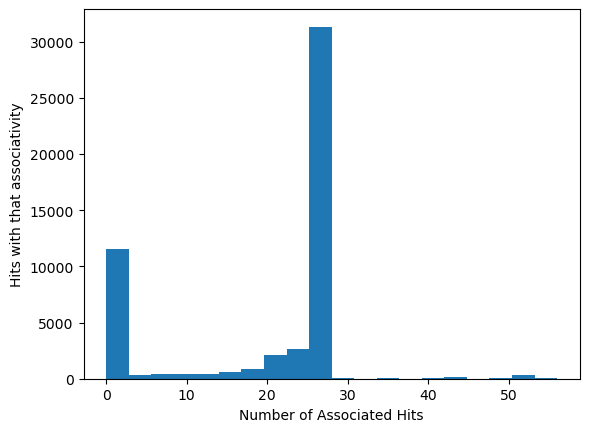

In [16]:
plt.hist(associated_hits_for_each_hit, bins=20)
plt.xlabel("Number of Associated Hits")
plt.ylabel("Hits with that associativity")
plt.show()

In [17]:
# Figure out what the most connected ones are
print("The maximum number of associations a hit has is ", max(associated_hits_for_each_hit))
print("And that hit (or those hits):", np.where(associated_hits_for_each_hit == max(associated_hits_for_each_hit))[0])
print("The minimum number of associations a hit has is ", min(associated_hits_for_each_hit))

The maximum number of associations a hit has is  56
And that hit (or those hits): [  294  3236  6027  9016 11165 12632 14413 15987 20059 21340 24455 25193
 28198 28948 31960 33295 35538 36852 38334 40153 43084 47111 47785 51134]
The minimum number of associations a hit has is  0


##### Investigate those with a distance of 0

In [18]:
# Get hits at the exact same frequency
same_frequency = find_collisions_at_threshold(0)

# Get their indices (which tell us what row of of the hits file to look for them in)
hit_indices = same_frequency.nonzero()
print(hit_indices)
print(hit_indices[0].shape)

(array([    2,     2,     2, ..., 49544, 49545, 49546], dtype=int32), array([ 3462,  5276,  5896, ..., 49918, 49919, 49920], dtype=int32))
(260849,)


In [19]:
# Get datasets of just the data that had a collision or didn't
indices_of_hits_with_collisions = np.unique(np.concatenate(hit_indices))
bool_indices_of_hits_with_collisions = np.zeros(len(first_source), dtype=bool)
bool_indices_of_hits_with_collisions[indices_of_hits_with_collisions] = True
zero_distance_dataset = first_source.iloc[bool_indices_of_hits_with_collisions]
non_zero_distance_dataset = first_source.iloc[~bool_indices_of_hits_with_collisions]
print(f"Collisions dataset: {zero_distance_dataset.shape}")
print(f"No Collisions dataset: {non_zero_distance_dataset.shape}")

Collisions dataset: (36159, 16)
No Collisions dataset: (15292, 16)


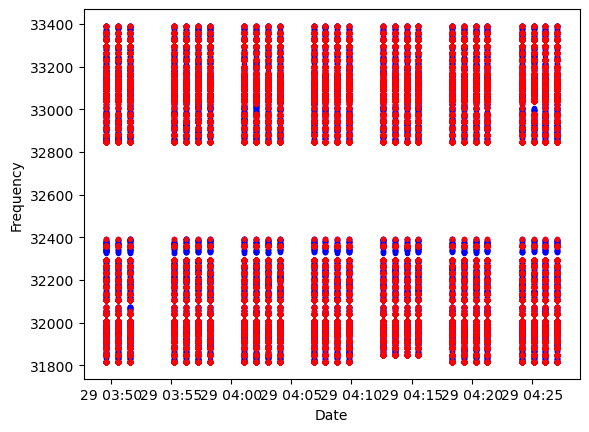

In [20]:
# Look at where they are with respect to all the data

# Plot all data
xaxis = first_source["tstart_h"]
yaxis = first_source["signal_frequency"]
plt.scatter(xaxis, yaxis, marker='.', color='blue')

# Plot just the hits which are the exact same as another hit
xaxis = zero_distance_dataset["tstart_h"]
yaxis = zero_distance_dataset["signal_frequency"]
plt.scatter(xaxis, yaxis, marker='.', color='red')

plt.xlabel("Date")
plt.ylabel("Frequency")
plt.show()

<Axes: xlabel='signal_frequency', ylabel='signal_snr'>

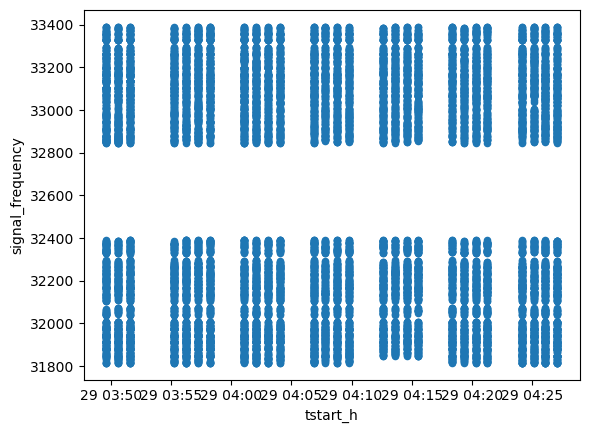

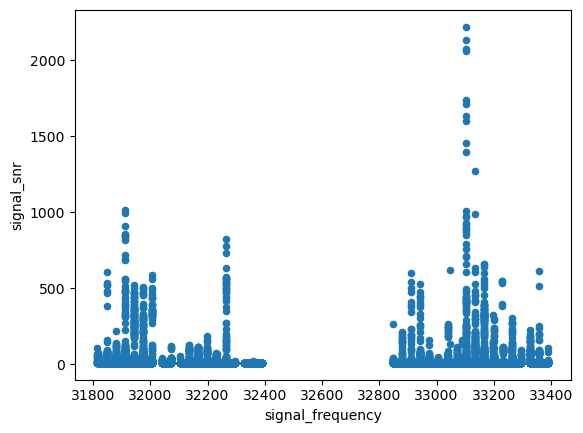

In [21]:
non_zero_distance_dataset.plot.scatter("tstart_h", "signal_frequency")
non_zero_distance_dataset.plot.scatter("signal_frequency", "signal_snr")

In [22]:
print(zero_distance_dataset.shape)

(36159, 16)


In [23]:
# Try filtering a different way and comparing just to check consistency
temp_groups = first_source.groupby("signal_frequency")
filtered_temp_groups = temp_groups.filter(lambda x: len(x) > 1)
# filtered_temp_groups.shape
filtered_temp_groups.equals(zero_distance_dataset)

True

In [24]:
(zero_distance_dataset.groupby("signal_frequency").size() < 2).sum()

0

###### Investigate hit 2

In [25]:
# So I'm seeing that the hit at index 2 is at the same frequency as several other hits. Let's just look at that
hit_index_to_look_at = 2
hit_index_to_look_at_freq = first_source["signal_frequency"][hit_index_to_look_at]
print("Hit", hit_index_to_look_at, "at", hit_index_to_look_at_freq, "MHz")
other_hit_indices = hit_indices[1][np.where(hit_indices[0] == hit_index_to_look_at)]
print("Same frequency as", other_hit_indices)

Hit 2 at 33262.708599607846 MHz
Same frequency as [ 3462  5276  5896  7851 10236 12117 13656 16318 17528 20712 21869 24006
 25464 27395 30077 31744 33932 34850 36884 38190 40533 41901 44528 49312
 49651]


In [26]:
# Just to be sure, let's print out all the frequencies and make sure they're the same
for i in other_hit_indices:
    this_frequency = first_source["signal_frequency"][i]
    assert(this_frequency == hit_index_to_look_at_freq)
    # print(this_frequency)

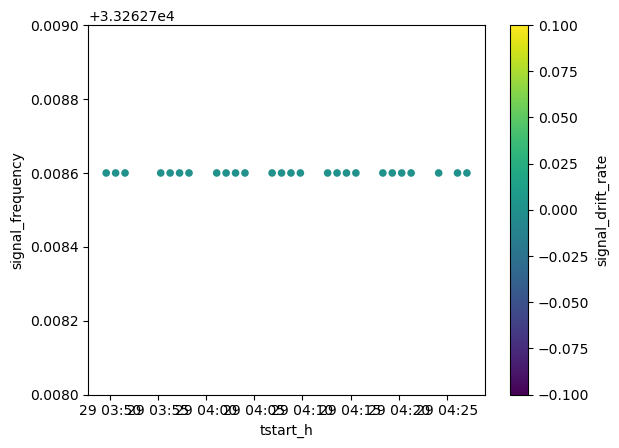

In [27]:
# Let's make a dataset that just has these points to mess around with
indices = np.concatenate(([hit_index_to_look_at], other_hit_indices))
small_dataset = first_source.iloc[indices]
small_dataset.plot.scatter("tstart_h", "signal_frequency", c="signal_drift_rate")
plt.ylim([33262.708, 33262.709])
plt.show()

In [28]:
for uri in small_dataset["file_uri"]:
    print(uri)

/mnt/cosmic-storage-1/data2/vla_target/23B-169.sb44930600.eb44962607.60307.145388159726/23B-169.sb44930600.eb44962607.60307.145388159726.9.1/23B-169.sb44930600.eb44962607.60307.145388159726.9.1.AC.C736.0000.raw.seticore.hits
/mnt/cosmic-storage-1/data2/vla_target/23B-169.sb44930600.eb44962607.60307.145388159726/23B-169.sb44930600.eb44962607.60307.145388159726.9.1/23B-169.sb44930600.eb44962607.60307.145388159726.9.1.AC.C736.0007.raw.seticore.hits
/mnt/cosmic-storage-1/data2/vla_target/23B-169.sb44930600.eb44962607.60307.145388159726/23B-169.sb44930600.eb44962607.60307.145388159726.9.1/23B-169.sb44930600.eb44962607.60307.145388159726.9.1.AC.C736.0014.raw.seticore.hits
/mnt/cosmic-storage-1/data2/vla_target/23B-169.sb44930600.eb44962607.60307.145388159726/23B-169.sb44930600.eb44962607.60307.145388159726.11.1/23B-169.sb44930600.eb44962607.60307.145388159726.11.1.AC.C736.0000.raw.seticore.hits
/mnt/cosmic-storage-1/data2/vla_target/23B-169.sb44930600.eb44962607.60307.145388159726/23B-169.sb

In [29]:
# Save out these stamps to look at later
cols_to_care_about = [
    "id",
    "file_uri",
    "file_local_enumeration",
]
small_dataset[cols_to_care_about].to_csv("/home/nstieg/BL-COSMIC-2024-proj/frequency_adjacency/stamps_of_flat_rfi.csv", index=False)

OSError: Cannot save file into a non-existent directory: '/home/nstieg/BL-COSMIC-2024-proj/frequency_adjacency'

In [ ]:
# So they really are the same frequency detected at different times!
# Let's see if any are the same frequency detected at the same time
print("There are", (small_dataset.groupby("tstart").size() > 1).sum(), "times with multiple hits")

There are 0 times with multiple hits


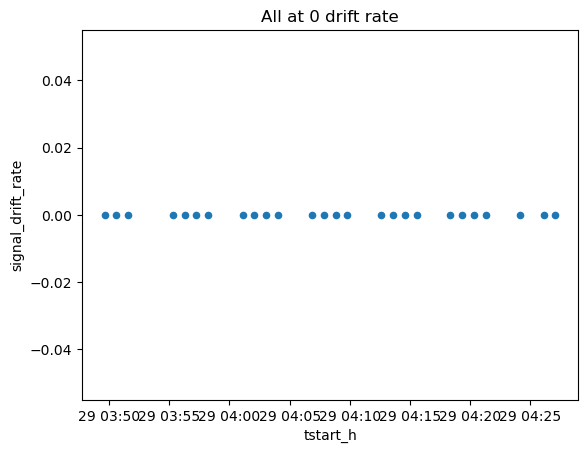

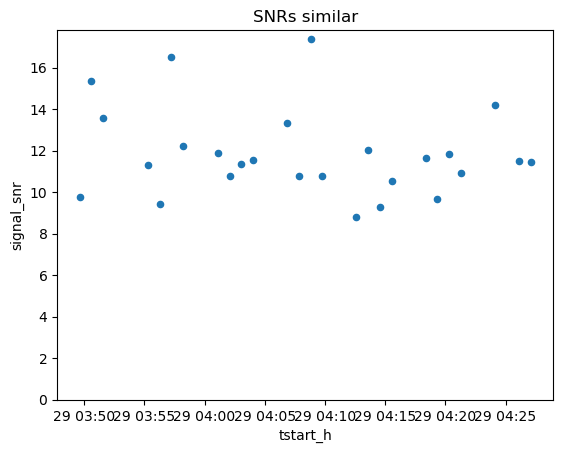

In [ ]:
# Let's look at other properties of the dataset
small_dataset.plot.scatter("tstart_h", "signal_drift_rate") 
plt.title("All at 0 drift rate")
plt.show()

small_dataset.plot.scatter("tstart_h", "signal_snr")
plt.ylim(bottom=0)
plt.title("SNRs similar")
plt.show()

###### Investigate nonzero DR

In [ ]:
# Were any of these signals detected with nonzero drift rate?
indices_of_nonzero_dr = zero_distance_dataset["signal_drift_rate"] != 0
print(indices_of_nonzero_dr.sum(), "signals with nonzero drift rate of", len(zero_distance_dataset), f"({round(indices_of_nonzero_dr.sum() / len(zero_distance_dataset) * 100, 2)}%)")
print("So most were detected with a zero drift rate")

3815 signals with nonzero drift rate of 36159 (10.55%)
So most were detected with a zero drift rate


In [ ]:
# Separate out the zero drift rate and nonzero drift rate signals
zero_dr_database = zero_distance_dataset[~indices_of_nonzero_dr]
nonzero_dr_database = zero_distance_dataset[indices_of_nonzero_dr]

In [ ]:
# Check all the zero dr signals still have a hit with another zero dr signal
(zero_dr_database.groupby("signal_frequency").size() < 2).sum()

691

In [ ]:
# Let's check how many of the nonzero dr signals had a 'hit' with a zero dr signal
(nonzero_dr_database.groupby("signal_frequency").size() < 2).sum()

1559

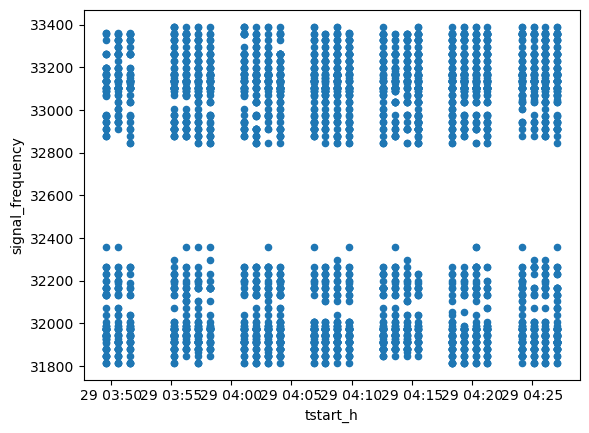

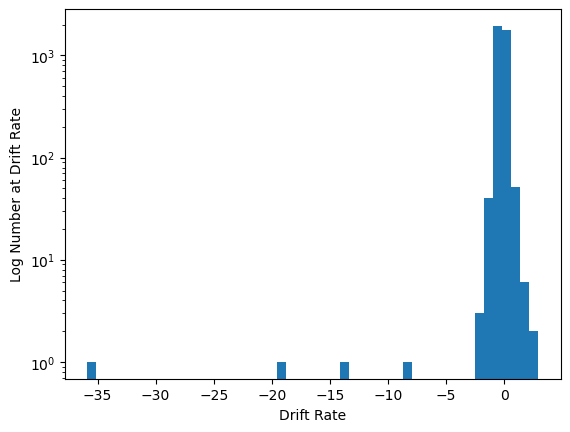

In [ ]:
# Let's look at those nonzero drift rate signals
nonzero_dr_database.plot.scatter("tstart_h", "signal_frequency")
plt.show()
plt.hist(nonzero_dr_database["signal_drift_rate"], bins=50)
plt.yscale("log")
plt.xlabel("Drift Rate")
plt.ylabel("Log Number at Drift Rate")
plt.show()

In [ ]:
# Let's check how many of these signals had a 'hit' with a zero dr signal
(nonzero_dr_database.groupby("signal_frequency").size() < 2).sum()

1559

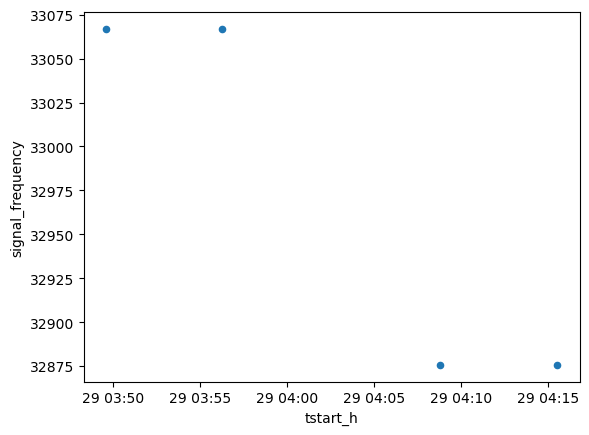

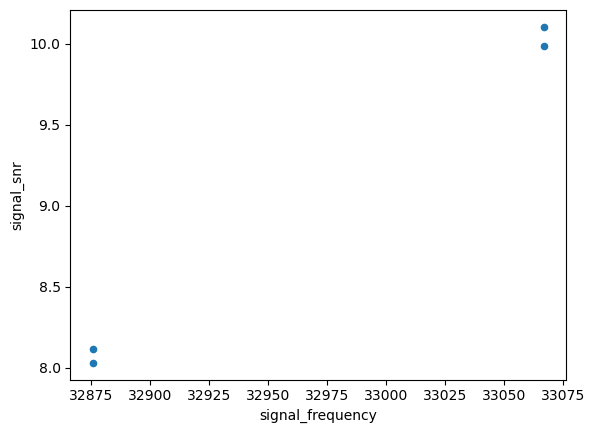

I guess I should look at the stamps to follow up?


In [ ]:
# Look at the outliers in drift rate. Hypothesis is that they're spurious signals
# which seticore is finding in the noise. Would expect them to have low SNR
large_dr = nonzero_dr_database[nonzero_dr_database["signal_drift_rate"].abs() > 5]
large_dr.plot.scatter("tstart_h", "signal_frequency")
plt.show()
large_dr.plot.scatter("signal_frequency", "signal_snr")
plt.show()
print("I guess I should look at the stamps to follow up?")

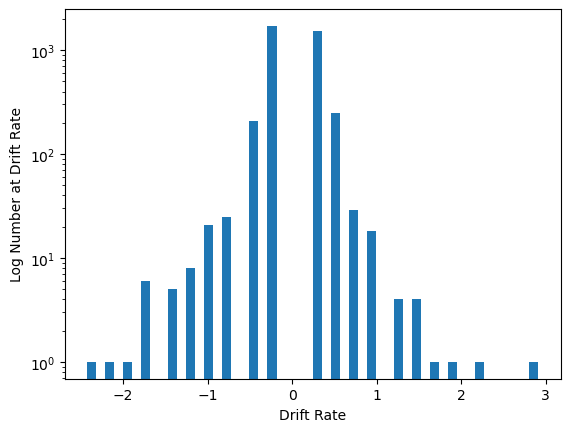

In [ ]:
small_dr = nonzero_dr_database[nonzero_dr_database["signal_drift_rate"].abs() < 5]
plt.hist(small_dr["signal_drift_rate"], bins=50)
plt.yscale("log")
plt.xlabel("Drift Rate")
plt.ylabel("Log Number at Drift Rate")
plt.show()

<Axes: xlabel='signal_frequency', ylabel='signal_snr'>

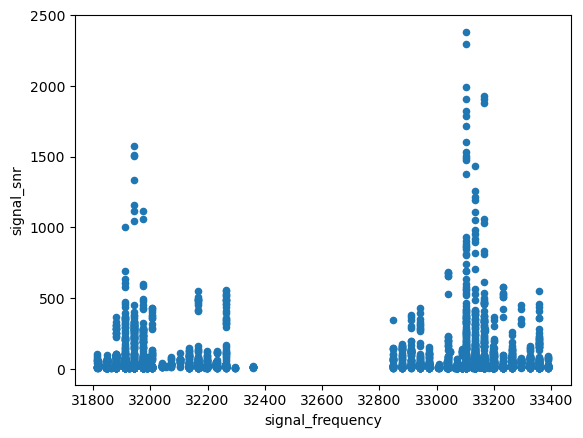

In [ ]:
small_dr.plot.scatter("signal_frequency", "signal_snr")

In [ ]:
small_groups = small_dr.groupby("signal_frequency")
(small_groups.size() == 1).sum()

1559

###### Invesigate hits which collided with nonzero and zero dr hits

In [ ]:
# Find all the groups which have both a zero drift rate and a nonzero drift rate signal
collision_groups = zero_distance_dataset.groupby("signal_frequency")
hits_in_mixed_collision_groups = collision_groups.filter(lambda x: (0 in x["signal_drift_rate"].values) and ((x["signal_drift_rate"].abs().values != 0.0).any()))
print(hits_in_mixed_collision_groups.shape)
mixed_collision_groups = hits_in_mixed_collision_groups.groupby("signal_frequency")
# mixed_collison_groups.first()
print(len(mixed_collision_groups))

(11777, 14)
2235


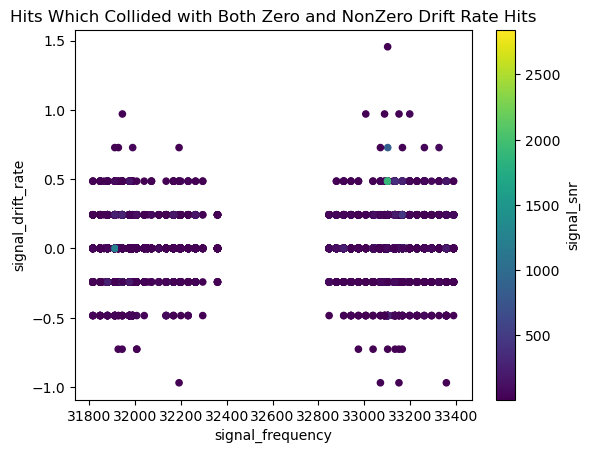

In [ ]:
hits_in_mixed_collision_groups.plot.scatter("signal_frequency", "signal_drift_rate", c="signal_snr")
plt.title("Hits Which Collided with Both Zero and NonZero Drift Rate Hits")
plt.show()